# *Case Study*
- "Optimizing Retail Promotions and Product Mix to Increase Seasonal Sales"

## *Business Problem*
*A retail chain operates across multiple cities with various store formats (Warehouse Club, Specialty Store, Department Store, Pharmacy). 
They run promotions and discounts but aren’t sure:*

- Which promotions actually drive sales?

- Which products/categories are most profitable in each season?

- How customer categories (Young Adults, Homemakers, Professionals, etc.) respond to promotions.

- Which store types and payment methods bring in higher revenue.

*Management wants to:*

- Increase seasonal sales without overspending on ineffective promotions.

- Tailor product offerings per city and season.

- Improve store type performance by aligning them with customer demand.

In [1]:
import pandas as pd 
import psycopg2 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency 

pd.set_option('display.float_format', '{:,.2f}'.format)


conn = psycopg2.connect(
    user= "postgres",
    host="localhost",
    database="postgres",
    password="1999",
    port="5432"
)
query = "SELECT * FROM RETAIL_TRANSACTION"
df = pd.read_sql_query(query,conn)

C:\Users\harsh\AppData\Local\Temp\ipykernel_14048\183921386.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query,conn)


In [2]:
df.head()

,transaction_id,date,customer_name,product,total_items,total_cost,payment_method,city,store_type,discount_applied,customer_category,season,promotion
0,1000000000,2022-01-21,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,None
1,1000000001,2023-03-01,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One)
2,1000000002,2024-03-21,Lisa Graves,['Spinach'],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,None
3,1000000003,2020-10-31,Mrs. Patricia May,"['Tissues', 'Mustard']",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,None
4,1000000004,2020-12-10,Susan Mitchell,['Dish Soap'],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items


In [3]:
df.isna().sum()

transaction_id       0
date                 0
customer_name        0
product              0
total_items          0
total_cost           0
payment_method       0
city                 0
store_type           0
discount_applied     0
customer_category    0
season               0
promotion            0
dtype: int64

In [4]:
# converting date into date type
df['date'] = pd.to_datetime(df['date'])

In [5]:
df['Year'] = df['date'].dt.year

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   transaction_id     1000000 non-null  int64         
 1   date               1000000 non-null  datetime64[ns]
 2   customer_name      1000000 non-null  object        
 3   product            1000000 non-null  object        
 4   total_items        1000000 non-null  int64         
 5   total_cost         1000000 non-null  float64       
 6   payment_method     1000000 non-null  object        
 7   city               1000000 non-null  object        
 8   store_type         1000000 non-null  object        
 9   discount_applied   1000000 non-null  object        
 10  customer_category  1000000 non-null  object        
 11  season             1000000 non-null  object        
 12  promotion          1000000 non-null  object        
 13  Year               1000000 n

In [7]:
# Adding useful metrics
df['sales'] = df['total_cost'] * df['total_items']

# profit
df['profit'] = df['sales'] - df['total_cost']

# profit_margin 
df['profit_margin'] = df['profit']/df['sales']*100

## *Promotion Analysis*

### Anova testing to test difference between promotions

In [8]:
import scipy.stats as stats
# Promotion Categories into groups
group_1 = df[df['promotion']=="None"]['sales']
group_2 = df[df['promotion']=="BOGO (Buy One Get One)"]['sales']
group_3 = df[df['promotion']=="Discount on Selected Items"]['sales']

anova_stats,p_val = stats.f_oneway(group_1,group_2,group_3)
print('Reject Ho: There is significant difference between the two' if p_val<=0.05 else 'Failed to reject Ho: No Difference in the groups')

Failed to reject Ho: No Difference in the groups


In [9]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model =ols('sales ~ C(promotion) + C(season) + C(promotion):C(season)',data=df).fit()
anova_table = sm.stats.anova_lm(model,type=2)
anova_table


,df,sum_sq,mean_sq,F,PR(>F)
C(promotion),2.00,"123,058.51","61,529.26",1.19,0.30
C(season),3.00,"290,006.17","96,668.72",1.88,0.13
C(promotion):C(season),6.00,"281,966.89","46,994.48",0.91,0.49
Residual,"999,988.00","51,543,991,690.91","51,544.61",NaN,NaN


In [10]:
# Downsample for quick test
df_sample = df.sample(n=10000, random_state=0)

model = ols('sales ~ C(promotion) + C(store_type) + C(customer_category) + \
            C(promotion):C(store_type) + C(promotion):C(customer_category) + \
            C(store_type):C(customer_category) + \
            C(promotion):C(store_type):C(customer_category)', data=df_sample).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(promotion),"217,272.41",2.00,2.17,0.11
C(store_type),"186,955.40",5.00,0.75,0.59
C(customer_category),"471,765.84",7.00,1.35,0.22
C(promotion):C(store_type),"116,078.91",10.00,0.23,0.99
C(promotion):C(customer_category),"418,408.74",14.00,0.60,0.87
C(store_type):C(customer_category),"1,877,991.40",35.00,1.07,0.35
C(promotion):C(store_type):C(customer_category),"2,560,508.65",70.00,0.73,0.95
Residual,"492,799,792.79","9,856.00",NaN,NaN


In [11]:
# Promotions with respect to sales
promotion_performance = df.groupby(['promotion','season']).agg(
    {
        "sales" : "sum"
    }
).sort_values(by='sales', ascending=False).reset_index()

# Calculate uplift for each promotion separately
baseline_sales = promotion_performance[promotion_performance['promotion'] == 'None']['sales'].iloc[0]
print(baseline_sales)
promotion_performance['uplift_%'] = ((promotion_performance['sales'] - baseline_sales) / baseline_sales) * 100
promotion_performance.sort_values(['promotion','season'],ascending=False)

24252460.21


,promotion,season,sales,uplift_%
6,None,Winter,"23,993,569.51",-1.07
0,None,Summer,"24,252,460.21",0.00
1,None,Spring,"24,090,259.65",-0.67
2,None,Fall,"24,085,819.91",-0.69
7,Discount on Selected Items,Winter,"23,979,898.46",-1.12
5,Discount on Selected Items,Summer,"23,994,900.85",-1.06
4,Discount on Selected Items,Spring,"24,060,536.59",-0.79
3,Discount on Selected Items,Fall,"24,063,628.39",-0.78
11,BOGO (Buy One Get One),Winter,"23,924,732.71",-1.35
9,BOGO (Buy One Get One),Summer,"23,947,559.64",-1.26


In [12]:
# Get baseline sales for each (customer_category, store_type)
category_store_perf = (
    df.groupby(['customer_category', 'store_type', 'promotion'])
    .agg(sales=('sales', 'sum'))
    .reset_index()
)

baseline_df = (
    category_store_perf[category_store_perf['promotion'] == 'None']
    .rename(columns={'sales': 'baseline_sales'})
    [['customer_category', 'store_type', 'baseline_sales']]
)

# Merge baseline into main df
category_store_perf = category_store_perf.merge(baseline_df, on=['customer_category', 'store_type'], how='inner')

# Calculate uplift per category-store combo
category_store_perf['uplift_%'] = round(
    (category_store_perf['sales'] - category_store_perf['baseline_sales']) 
    / category_store_perf['baseline_sales'] * 100
,2)

category_store_perf = category_store_perf[category_store_perf['uplift_%']> 0][['customer_category','store_type','promotion','sales','baseline_sales','uplift_%']]
df_plot = category_store_perf.groupby('promotion').apply(lambda x: x.nlargest(3,'uplift_%'))
df_plot

C:\Users\harsh\AppData\Local\Temp\ipykernel_14048\3556218761.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_plot = category_store_perf.groupby('promotion').apply(lambda x: x.nlargest(3,'uplift_%'))


customer_category         store_type  \
promotion                                                             
BOGO (Buy One Get One)     108          Teenager  Convenience Store   
                           27        Middle-Aged    Specialty Store   
                           51       Professional     Warehouse Club   
Discount on Selected Items 52       Professional     Warehouse Club   
                           16          Homemaker     Warehouse Club   
                           76     Senior Citizen   Department Store   

                                                 promotion        sales  \
promotion                                                                 
BOGO (Buy One Get One)     108      BOGO (Buy One Get One) 2,076,750.81   
                           27       BOGO (Buy One Get One) 2,003,145.15   
                           51       BOGO (Buy One Get One) 1,977,640.77   
Discount on Selected Items 52   Discount on Selected Items 2,034,164.77   
                           16   Discount on Selected Items 2,068,512.14   
                           76   Discount on Selected Items 2,047,470.27   

                                baseline_sales  uplift_%  
promotion                                                 
BOGO (Buy One Get One)     108    1,996,154.96      4.04  
                           27     1,957,928.90      2.31  
                           51     1,935,154.16      2.20  
Discount on Selected Items 52     1,935,154.16      5.12  
                           16     2,009,813.19      2.92  
                           76     1,993,168.22      2.72

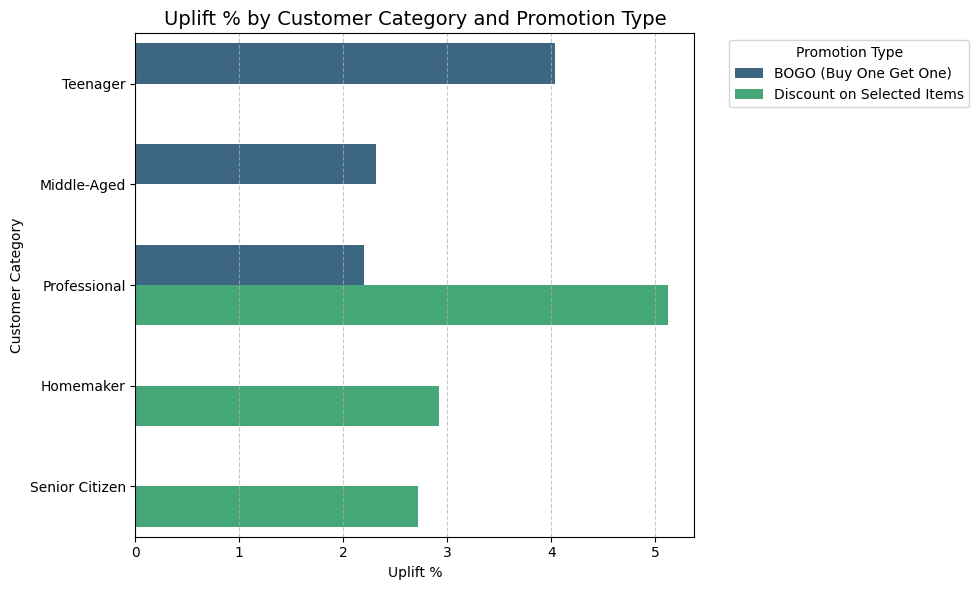

In [76]:
# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x='uplift_%', y='customer_category', hue='promotion', palette='viridis')

plt.title('Uplift % by Customer Category and Promotion Type', fontsize=14)
plt.xlabel('Uplift %')
plt.ylabel('Customer Category')
plt.legend(title='Promotion Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Customer Category and Promotion Type.png')
plt.show()

### **Promotions Driving Sales**

* **Best performing promotion:**
    * "Discount on Selected Items" for Professionals in Warehouse Club with an Uplift: +5.12%.
    * Targeted discounts for professionals in a warehouse setting work exceptionally well.
* **BOGO (Buy One Get One) for Teenagers:**
    * BOGO (Buy One Get One) for Teenagers in Convenience Stores with Uplift: +4.04%.
    * High sales volume and strong percentage uplift indicate this is a very effective impulse-buy strategy for younger customers in small-format stores.
* **Promotions for Middle-aged & Homemakers show moderate impact:**
    * Middle-aged in Specialty Stores with BOGO: +2.31% uplift
    * Homemakers in Discount Stores with "Discount on Selected Items": +2.92% uplift
* **Targeted promotions work better than blanket campaigns:**
    * Top uplifts are not spread evenly; certain customer segments + store types dominate results.
    * Professionals in Warehouse Clubs consistently appear in the top list, suggesting a strong alignment between product mix, bulk buying, and targeted discounts.

### Which products/categories are most profitable in each season?

In [14]:
import ast
df['product'] = df['product'].apply(ast.literal_eval)

In [15]:
df_exploded = df.explode('product')
df_exploded.head(1)

,transaction_id,date,customer_name,product,total_items,total_cost,payment_method,city,store_type,discount_applied,customer_category,season,promotion,Year,sales,profit,profit_margin
0,1000000000,2022-01-21,Stacey Price,Ketchup,3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,None,2022,214.95,143.30,66.67


In [16]:
product_categories = {
    'Groceries': [
        'Ketchup', 'Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'Potatoes', 'Spinach',
        'Mustard', 'Chicken', 'Honey', 'BBQ Sauce', 'Soda', 'Syrup', 'Pancake Mix',
        'Water', 'Mayonnaise', 'Tea', 'Salmon', 'Apple', 'Beef', 'Cereal', 'Vinegar',
        'Coffee', 'Shrimp', 'Peanut Butter', 'Pickles', 'Tomatoes', 'Chips',
        'Butter', 'Yogurt', 'Onions', 'Tuna', 'Eggs', 'Pasta', 'Carrots', 'Orange',
        'Cereal Bars', 'Banana', 'Canned Soup', 'Cheese', 'Jam', 'Rice'
    ],
    'Personal Care': [
        'Shaving Cream', 'Tissues', 'Toothpaste', 'Soap', 'Baby Wipes', 'Hair Gel',
        'Razors', 'Feminine Hygiene Products', 'Shampoo', 'Shower Gel',
        'Hand Sanitizer', 'Deodorant', 'Diapers', 'Toothbrush'
    ],
    'Household Goods': [
        'Light Bulbs', 'Dish Soap', 'Trash Cans', 'Insect Repellent', 'Cleaning Spray',
        'Paper Towels', 'Trash Bags', 'Mop', 'Laundry Detergent', 'Bath Towels',
        'Air Freshener', 'Dustpan', 'Iron', 'Toilet Paper', 'Dishware', 'Sponges',
        'Broom', 'Cleaning Rags', 'Ironing Board'
    ],
    'Home & Garden': [
        'Garden Hose', 'Extension Cords', 'Power Strips', 'Vacuum Cleaner',
        'Plant Fertilizer', 'Lawn Mower'
    ]
}

# dictionary where products are keys and categories are values
product_mapping = {}
for category, products in product_categories.items():
    for product in products:
        product_mapping[product] = category

df_exploded['product_category']=df_exploded['product'].map(product_mapping)
df_exploded['product_category'].unique()

array(['Groceries', 'Personal Care', 'Household Goods', 'Home & Garden'],
      dtype=object)

#### Fromatting Numerical Values to "K" thousands and millions "M"

In [17]:
def format_number(value):
    if pd.isna(value):
        return 'N/A'
    abs_value = abs(value)
    if abs_value>=1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif abs_value>=1_000:
        return f"{value/1_000:.2f}K"
    else:
        return f"{value:.2f}"
    

#### Product Performance by Each Season

In [91]:
def product_performance_by_season():

        season_wise_prod_perf = df_exploded.groupby(['season','product']).agg({
            'sales':'sum',
            'profit':'sum',
            'profit_margin':'sum'
        })
        season_sale = season_wise_prod_perf.groupby(level=0,group_keys=False).apply(lambda x: x.nlargest(3,'sales'))
        # --------Total sales
        season_sale['sales']= season_sale['sales'].apply(format_number)
        season_sale['profit']= season_sale['profit'].apply(format_number)
        season_sale['profit_margin']= season_sale['profit_margin'].apply(format_number)
        
        return print(season_sale)

product_performance_by_season()

                         sales profit profit_margin
season product                                     
Fall   Toothpaste        5.37M  4.40M         1.31M
       Ironing Board     2.73M  2.23M       666.75K
       Air Freshener     2.72M  2.23M       663.12K
Spring Toothpaste        5.26M  4.30M         1.29M
       Soap              2.72M  2.23M       665.16K
       Yogurt            2.72M  2.23M       659.60K
Summer Toothpaste        5.29M  4.33M         1.30M
       Extension Cords   2.75M  2.25M       662.41K
       Ice Cream         2.74M  2.24M       663.50K
Winter Toothpaste        5.26M  4.31M         1.30M
       Insect Repellent  2.71M  2.23M       656.39K
       Orange            2.70M  2.21M       667.13K


#### Product Category Performance by Season

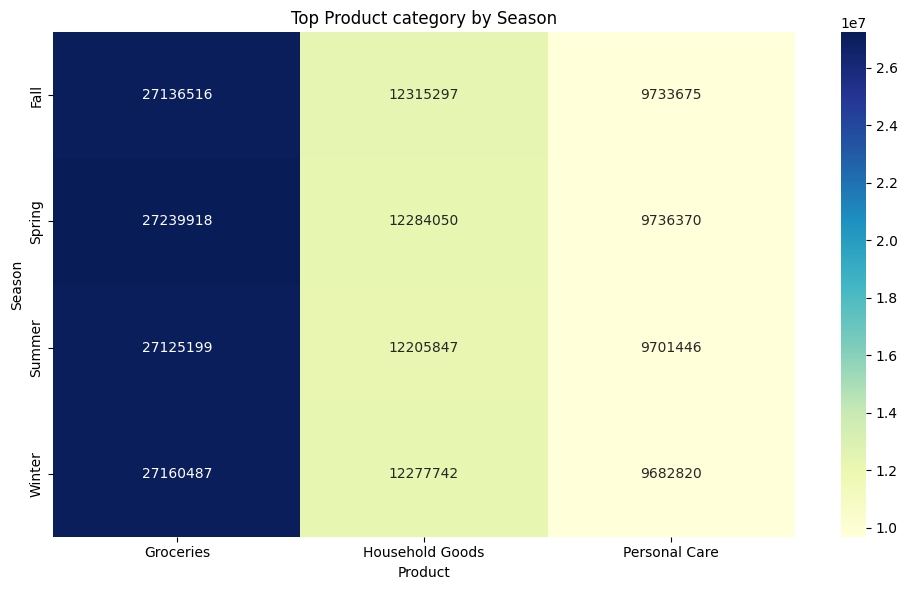

                           sales  profit profit_margin
season product_category                               
Fall   Groceries         110.63M  90.45M        27.14M
       Household Goods    50.19M  41.03M        12.32M
       Personal Care      39.78M  32.55M         9.73M
Spring Groceries         111.08M  90.91M        27.24M
       Household Goods    49.95M  40.86M        12.28M
       Personal Care      39.60M  32.39M         9.74M
Summer Groceries         111.03M  90.86M        27.13M
       Household Goods    49.91M  40.84M        12.21M
       Personal Care      39.73M  32.52M         9.70M
Winter Groceries         110.62M  90.48M        27.16M
       Household Goods    50.03M  40.93M        12.28M
       Personal Care      39.47M  32.28M         9.68M


In [ ]:
def product_category_performance_by_season():

    #Grouping product categories by season
    season_wise_prod_category_perf = df_exploded.groupby(['season','product_category']).agg({
                'sales':'sum',
                'profit':'sum',
                'profit_margin':'sum'
            })
    
    # Top 3 product category with highest sales
    season_Sale = season_wise_prod_category_perf.groupby(level=0,group_keys=False).apply(lambda x: x.nlargest(3,'sales'))
    
    # Product category performance by profit 
    pivot_table = season_Sale.reset_index().pivot(index='season',columns='product_category',values='profit_margin')
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='YlGnBu')
    plt.title('Top Product category by Season')
    plt.ylabel('Season')
    plt.xlabel('Product category')
    plt.tight_layout()
    # saving figure as png 
    plt.savefig('Product category performance by profit.png')
    plt.show()

    # Formatting numbers to "K" & "M"
    season_Sale['profit_margin']= season_Sale['profit_margin'].apply(format_number)
    season_Sale['profit']= season_Sale['profit'].apply(format_number)
    season_Sale['sales']= season_Sale['sales'].apply(format_number)
    
    return print(season_Sale)

product_category_performance_by_season()

### **Product and Seasonal Profitability Analysis**

#### Key Insights:

* **Toothpaste is a consistently strong performer:** In every season (Fall, Spring, Summer, and Winter), Toothpaste is the top-selling product in terms of sales and profit, consistently generating a high profit margin of approximately 1.30M. This indicates a stable, year-round demand for this product.

* **Seasonal Product Performance:**
    * **Fall:** The best-performing products after Toothpaste are Ironing Boards and Air Fresheners, with similar sales and profit figures.
    * **Spring:** Soap and Yogurt show comparable performance after Toothpaste.
    * **Summer:** Extension Cords and Ice Cream are the top performers after Toothpaste. This is expected as these products are often used during the summer months.
    * **Winter:** Insect Repellent and Oranges are notable products, with Oranges having the highest profit margin among the non-toothpaste products at 667.13K.

* **Profit Margins are relatively consistent:** For most products (excluding Toothpaste), the profit margins are very similar, generally falling in the range of 659K to 667K, regardless of the season.

* **High-level trends:**
    * Sales figures for most products (other than Toothpaste) are clustered around 2.7M.
    * Profit figures for these products are also consistently around 2.2M to 2.25M.

### **Customer Response to Promotions**

* **BOGO can be highly effective:**
    * Teenagers and Professionals, in particular, show a strong uplift of around 4% when the BOGO promotion is run in a Convenience Store or Pharmacy. This indicates that the BOGO offer is a good fit for the shopping habits and product mix of these store types.

* **Discounts are context-dependent:**
    * The "Discount on Selected Items" promotion also shows significant uplift when broken down by store type.
    * The highest uplift of 5.15% is seen for Professionals in a Pharmacy. This suggests that these promotions resonate with professionals looking for specific items in a pharmacy setting.

In [88]:
cust_cat_to_promo = df.groupby(['promotion','customer_category','store_type']).agg({
    'sales':'sum'
}).reset_index()
baseline_sales_no_promo = cust_cat_to_promo[cust_cat_to_promo['promotion']=="None"].rename(columns={'sales':'baseline_sale'})[['customer_category','baseline_sale']]
cust_cat_to_promo_df = cust_cat_to_promo.merge(baseline_sales_no_promo,on='customer_category',how='left')
cust_cat_to_promo_df['uplift_%'] = ((cust_cat_to_promo_df['sales'] - cust_cat_to_promo_df['baseline_sale']) / cust_cat_to_promo_df['baseline_sale']) * 100

# formatting sales,baseline_sale and uplift% 
cust_cat_to_promo_df['sales'] = cust_cat_to_promo_df['sales'].apply(format_number)
cust_cat_to_promo_df['baseline_sale'] = cust_cat_to_promo_df['baseline_sale'].apply(format_number)

C:\Users\harsh\AppData\Local\Temp\ipykernel_14048\239487682.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  customer_promo = cust_cat_to_promo_df[cust_cat_to_promo_df['promotion'] !="None"].groupby('customer_category').apply(lambda x: x.nlargest(3,'uplift_%'))


promotion customer_category  \
customer_category                                                     
Homemaker         322  Discount on Selected Items         Homemaker   
                  318  Discount on Selected Items         Homemaker   
                  323  Discount on Selected Items         Homemaker   
Middle-Aged       333  Discount on Selected Items       Middle-Aged   
                  327  Discount on Selected Items       Middle-Aged   
                  45       BOGO (Buy One Get One)       Middle-Aged   
Professional      377  Discount on Selected Items      Professional   
                  395  Discount on Selected Items      Professional   
                  383  Discount on Selected Items      Professional   
Retiree           416  Discount on Selected Items           Retiree   
                  410  Discount on Selected Items           Retiree   
                  422  Discount on Selected Items           Retiree   
Senior Citizen    441  Discount on Selected Items    Senior Citizen   
                  443  Discount on Selected Items    Senior Citizen   
                  439  Discount on Selected Items    Senior Citizen   
Student           480  Discount on Selected Items           Student   
                  468  Discount on Selected Items           Student   
                  210      BOGO (Buy One Get One)           Student   
Teenager          217      BOGO (Buy One Get One)          Teenager   
                  216      BOGO (Buy One Get One)          Teenager   
                  219      BOGO (Buy One Get One)          Teenager   
Young Adult       554  Discount on Selected Items       Young Adult   
                  556  Discount on Selected Items       Young Adult   
                  557  Discount on Selected Items       Young Adult   

                              store_type  sales baseline_sale  uplift_%  
customer_category                                                        
Homemaker         322     Warehouse Club  2.07M         2.00M      3.30  
                  318     Warehouse Club  2.07M         2.00M      3.24  
                  323     Warehouse Club  2.07M         2.01M      2.92  
Middle-Aged       333   Department Store  2.03M         1.96M      3.52  
                  327  Convenience Store  2.01M         1.96M      2.89  
                  45    Department Store  2.01M         1.96M      2.59  
Professional      377           Pharmacy  2.03M         1.94M      5.15  
                  395     Warehouse Club  2.03M         1.94M      5.12  
                  383    Specialty Store  2.02M         1.94M      4.46  
Retiree           416    Specialty Store  2.02M         1.99M      1.42  
                  410           Pharmacy  2.02M         1.99M      1.34  
                  422        Supermarket  2.02M         1.99M      1.30  
Senior Citizen    441   Department Store  2.05M         1.99M      3.02  
                  443   Department Store  2.05M         1.99M      2.77  
                  439   Department Store  2.05M         1.99M      2.72  
Student           480           Pharmacy  2.03M         1.98M      2.53  
                  468  Convenience Store  2.02M         1.98M      2.41  
                  210     Warehouse Club  2.01M         1.98M      1.86  
Teenager          217  Convenience Store  2.08M         1.99M      4.49  
                  216  Convenience Store  2.08M         2.00M      4.04  
                  219  Convenience Store  2.08M         2.01M      3.35  
Young Adult       554           Pharmacy  2.03M         1.98M      2.36  
                  556           Pharmacy  2.03M         1.98M      2.28  
                  557           Pharmacy  2.03M         1.99M      2.04

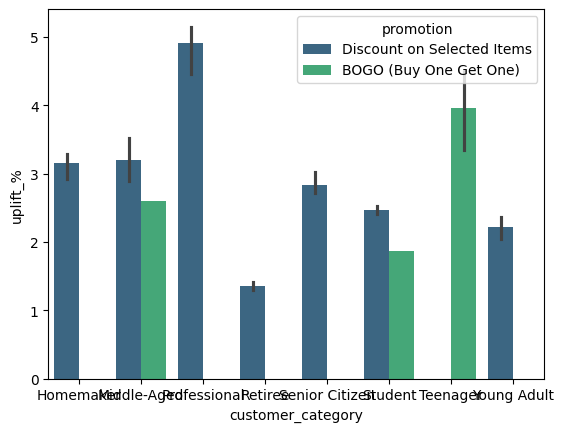

In [109]:
customer_promo = cust_cat_to_promo_df[cust_cat_to_promo_df['promotion'] !="None"].groupby('customer_category').apply(lambda x: x.nlargest(3,'uplift_%'))
sns.barplot(data=customer_promo,x='customer_category',y='uplift_%',hue='promotion',palette='viridis')
customer_promo

### **Store Type and Payment Method Performance Analysis**

#### **Summary:**
* Revenue, profit, and profit margin are nearly identical across all store types and payment methods in your data, with consistently high margins (~81.8%). 
* No single store type or payment method stands out in performance. 
*This indicates very balanced business operations.*

C:\Users\harsh\AppData\Local\Temp\ipykernel_14048\3179453777.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stores_revenue.reset_index(), x='store_type', y='profit_margin', ax=axes[0], palette='viridis')


--------------------------------------------------stores_revenue-------------------------------------------------- 

                      sales total_cost   profit profit_margin
store_type                                                  
Convenience Store  144.46M     26.24M  118.22M         81.84
Department Store   144.08M     26.21M  117.87M         81.81
Pharmacy           144.57M     26.30M  118.27M         81.81
Specialty Store    143.63M     26.06M  117.57M         81.86
Supermarket        144.28M     26.28M  118.00M         81.79
Warehouse Club     144.47M     26.35M  118.11M         81.76


C:\Users\harsh\AppData\Local\Temp\ipykernel_14048\3179453777.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=paymode_revenue.reset_index(), x='payment_method', y='profit_margin', ax=axes[1], palette='mako')


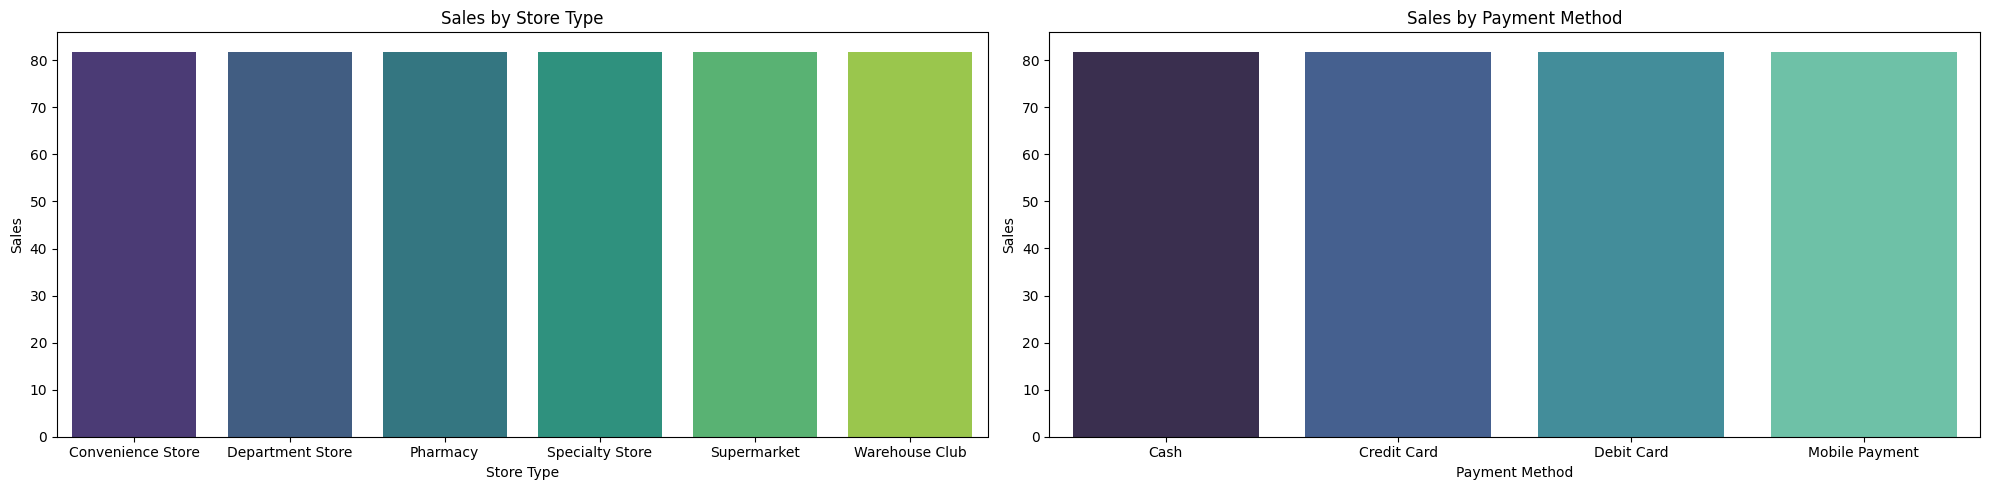

--------------------------------------------------payment_revenue-------------------------------------------------- 

                   sales total_cost   profit profit_margin
payment_method                                           
Cash            216.83M     39.42M  177.41M         81.82
Credit Card     216.67M     39.43M  177.25M         81.80
Debit Card      215.79M     39.30M  176.49M         81.79
Mobile Payment  216.19M     39.30M  176.89M         81.82
--------------------------------------------------store_and_pay-------------------------------------------------- 

                                                     sales total_cost profit  \
customer_category store_type        payment_method                            
Homemaker         Convenience Store Cash            4.49M    824.07K  3.67M   
                                    Credit Card     4.59M    821.79K  3.77M   
                                    Debit Card      4.54M    822.79K  3.72M   
                     

In [75]:
def stores_and_paymode_revenue():
            stores_revenue = df_exploded.groupby('store_type').agg({
                    'sales':'sum',
                'total_cost':'sum',
                'profit':"sum"
            })
            # Calculate profit margin first—while columns are numeric
            stores_revenue['profit_margin'] = (stores_revenue['profit'] / stores_revenue['sales']) * 100

            fig, axes = plt.subplots(1, 2, figsize=(20,5))
            sns.barplot(data=stores_revenue.reset_index(), x='store_type', y='profit_margin', ax=axes[0], palette='viridis')
            axes[0].set_title('Sales by Store Type')
            axes[0].set_ylabel('Sales')
            axes[0].set_xlabel('Store Type')
           
            # format numeric columns (after all math!)
            stores_revenue['sales'] = stores_revenue['sales'].apply(format_number)
            stores_revenue['total_cost'] = stores_revenue['total_cost'].apply(format_number)
            stores_revenue['profit'] = stores_revenue['profit'].apply(format_number)
            stores_revenue['profit_margin'] = stores_revenue['profit_margin'].apply(format_number)  # (optional)
            print('-'*50 + 'stores_revenue' + '-'*50,'\n\n',stores_revenue)

            paymode_revenue = df_exploded.groupby('payment_method').agg({
                 'sales':'sum',
                'total_cost':'sum',
                'profit':"sum"
            })
            # Calculate profit margin 
            paymode_revenue['profit_margin'] = (paymode_revenue['profit'] / paymode_revenue['sales']) * 100
            sns.barplot(data=paymode_revenue.reset_index(), x='payment_method', y='profit_margin', ax=axes[1], palette='mako')
            axes[1].set_title('Sales by Payment Method')
            axes[1].set_ylabel('Sales')
            axes[1].set_xlabel('Payment Method')
            
            plt.savefig('Sales by store_type and Payment Method.png')
            plt.tight_layout()
            plt.show()
            # format numeric columns (after all math!)
            paymode_revenue['sales']=paymode_revenue['sales'].apply(format_number)
            paymode_revenue['total_cost']=paymode_revenue['total_cost'].apply(format_number)
            paymode_revenue['profit']=paymode_revenue['profit'].apply(format_number)
            paymode_revenue['profit_margin']=paymode_revenue['profit_margin'].apply(format_number)
            print('-'*50 + 'payment_revenue' + '-'*50,'\n\n',paymode_revenue)

            store_and_pay = df_exploded.groupby(['customer_category','store_type','payment_method']).agg({
                'sales':'sum',
                'total_cost':'sum',
                'profit':"sum"
            })
            store_and_pay['profit_margin'] = ((store_and_pay['profit'])/store_and_pay['sales'])*100

            store_and_pay['sales']=(store_and_pay['sales']).apply(format_number)
            store_and_pay['total_cost']=store_and_pay['total_cost'].apply(format_number)
            store_and_pay['profit']=store_and_pay['profit'].apply(format_number)
              
            print('-'*50 + 'store_and_pay' + '-'*50,'\n\n',store_and_pay)
            
stores_and_paymode_revenue()

# **Optimizing Retail Promotions and Product Mix**

***

### **1. Promotion Analysis**

#### **Increase Seasonal Sales Without Overspending on Ineffective Promotions**

* **Targeted Promotions are Key:** Blanket campaigns do not perform as well as targeted promotions. The analysis shows that certain customer segments and store types have a significantly higher uplift from specific promotions.
* **Best-Performing Promotions:**
    * **Discount on Selected Items:** This promotion works best for Professionals in a Warehouse Club setting, with a sales uplift of +5.12%. It also shows a high uplift of 5.15% for Professionals in a Pharmacy.
    * **BOGO (Buy One Get One):** This promotion is highly effective for Teenagers in Convenience Stores, resulting in a +4.04% uplift. It also shows a strong uplift of around 4% for Teenagers and Professionals in Convenience Stores or Pharmacies.
* **Moderate Impact:** Promotions for Middle-aged customers in Specialty Stores with BOGO had a +2.31% uplift, and for Homemakers in Discount Stores with "Discount on Selected Items," the uplift was +2.92%.

### **2. Product and Seasonal Analysis**

#### **Tailor Product Offerings and Season**

* **Consistently Strong Performer:** Toothpaste is the top-selling product in terms of sales and profit across all seasons (Fall, Spring, Summer, and Winter), with a consistently high profit margin of approximately 1.30M.
* **Seasonal Product Trends:**
    * **Fall:** The best-performing products after Toothpaste are Ironing Boards and Air Fresheners.
    * **Spring:** Soap and Yogurt show comparable performance after Toothpaste.
    * **Summer:** Extension Cords and Ice Cream are top performers after Toothpaste, which is expected for the season.
    * **Winter:** Insect Repellent and Oranges are notable products, with Oranges having a high profit margin.
* **Top-Performing Categories:** At a high level, Groceries are the top-performing product category across all seasons.

### **3. Store and Payment Analysis**

#### **Improve Store Type Performance**

* **Store and Payment Methods:** The analysis found that revenue, profit, and profit margins are nearly identical across all store types and payment methods.
* **Balanced Performance:** No single store type or payment method stands out, indicating very balanced business operations.
* **Strategic Alignment:** The data suggests a strong alignment between product mix, bulk buying, and targeted discounts for Professionals in Warehouse Clubs, which consistently appears on the top-performing list.